In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### download data

In [2]:
#! wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
#! unzip ml-1m.zip

### define description and load data

In [3]:
age_desc = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
occupation_desc = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [4]:
rating_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=['userid', 'movieid', 'rating', 'timestamp'])

user_data = pd.read_csv(
    "ml-1m/users.dat", 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['userid', 'gender', 'age', 'occupation', 'zipcode']
)
user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])

movie_data = pd.read_csv(
    "ml-1m/movies.dat",
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movieid', 'title', 'genre']
)

dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")

### train validation split

In [5]:
dataset = dataset.sample(frac=1, replace=False)

In [6]:
n_split = int(len(dataset)*.7)
trainset = dataset[:n_split]
validset = dataset[n_split:]

### build the model

In [7]:
def create_embeddings(num_users, num_movies, dim):
    user_embeddings = tf.get_variable(
        "theta",
        shape = [num_users, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_embeddings = tf.get_variable(
        "phi",
        shape = [num_movies, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_embeddings, movie_embeddings

def create_dataset(user_ids, movie_ids, ratings):
    user_id_var = tf.get_variable("userid", initializer=user_ids, trainable=False)
    movie_id_var = tf.get_variable("movieid", initializer=movie_ids, trainable=False)
    ratings_var = tf.get_variable("ratings", initializer=np.asarray(ratings, dtype=np.float32), trainable=False)
    return user_id_var, movie_id_var, ratings_var

def lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids): 
    selected_user_embeddings = tf.gather(user_embeddings, user_ids)
    selected_movie_embeddings = tf.gather(movie_embeddings, movie_ids)
    return selected_user_embeddings, selected_movie_embeddings

def predict(selected_user_embeddings, selected_movie_embeddings):
    selected_predictions = tf.reduce_sum(
        selected_user_embeddings * selected_movie_embeddings,
        axis = 1
    )
    return selected_predictions

def colaborative_filtering(user_embeddings, movie_embeddings, user_ids, movie_ids):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    predictions = predict(sel_usr_embs, sel_mov_embs)
    return predictions

def mean_squared_difference(predictions, ratings):
    difference = tf.reduce_mean(tf.squared_difference(predictions, ratings))
    return difference

### set hyper parameters

In [8]:
emb_dim = 8
learning_rate = 50
epochs = 1000

### train model

In [9]:
with tf.Graph().as_default():
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = create_embeddings(dataset.userid.max()+1, dataset.movieid.max()+1, emb_dim)
    with tf.variable_scope("train_set"):
        train_data = trainset[["userid", "movieid", "rating"]].values.T
        train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)
    with tf.variable_scope("valid_set"):
        valid_data = validset[["userid", "movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_preds = colaborative_filtering(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
        train_loss = mean_squared_difference(train_preds, train_ratings)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
        train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs])   
    with tf.variable_scope("validation"):
        valid_preds = colaborative_filtering(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
        valid_loss = mean_squared_difference(valid_preds, valid_ratings)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('Graph',sess.graph)
        sess.run(tf.global_variables_initializer())
        train_loss_history = []
        valid_loss_history = []
        for i in range(epochs):
            current_train_loss, _ = sess.run([train_loss, train_usr_embs])
            print("train loss after %ith user emb. opt. step: %f"%(i+1, current_train_loss))
            current_train_loss, _ = sess.run([train_loss, train_mov_embs])
            print("train loss after %ith movie emb. opt. step: %f"%(i+1, current_train_loss))
            current_valid_loss = sess.run(valid_loss)
            print("valid loss after %ith movie emb. opt. step: %f"%(i+1, current_valid_loss))
            train_loss_history.append(current_train_loss)
            valid_loss_history.append(current_valid_loss)
        final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
        final_valid_predictions = sess.run(valid_preds) 
        writer.close()

train loss after 1th user emb. opt. step: 14.073086
train loss after 1th movie emb. opt. step: 14.073039
valid loss after 1th movie emb. opt. step: 14.081543
train loss after 2th user emb. opt. step: 14.072985
train loss after 2th movie emb. opt. step: 14.072932
valid loss after 2th movie emb. opt. step: 14.081554
train loss after 3th user emb. opt. step: 14.072889
train loss after 3th movie emb. opt. step: 14.072841
valid loss after 3th movie emb. opt. step: 14.081553
train loss after 4th user emb. opt. step: 14.072782
train loss after 4th movie emb. opt. step: 14.072729
valid loss after 4th movie emb. opt. step: 14.081525
train loss after 5th user emb. opt. step: 14.072659
train loss after 5th movie emb. opt. step: 14.072611
valid loss after 5th movie emb. opt. step: 14.081496
train loss after 6th user emb. opt. step: 14.072554
train loss after 6th movie emb. opt. step: 14.072485
valid loss after 6th movie emb. opt. step: 14.081445
train loss after 7th user emb. opt. step: 14.072405


train loss after 53th movie emb. opt. step: 2.302391
valid loss after 53th movie emb. opt. step: 2.304752
train loss after 54th user emb. opt. step: 2.254736
train loss after 54th movie emb. opt. step: 2.208976
valid loss after 54th movie emb. opt. step: 2.215056
train loss after 55th user emb. opt. step: 2.165630
train loss after 55th movie emb. opt. step: 2.123997
valid loss after 55th movie emb. opt. step: 2.133297
train loss after 56th user emb. opt. step: 2.084449
train loss after 56th movie emb. opt. step: 2.046501
valid loss after 56th movie emb. opt. step: 2.058608
train loss after 57th user emb. opt. step: 2.010314
train loss after 57th movie emb. opt. step: 1.975611
valid loss after 57th movie emb. opt. step: 1.990170
train loss after 58th user emb. opt. step: 1.942434
train loss after 58th movie emb. opt. step: 1.910612
valid loss after 58th movie emb. opt. step: 1.927323
train loss after 59th user emb. opt. step: 1.880106
train loss after 59th movie emb. opt. step: 1.850870

train loss after 106th user emb. opt. step: 1.004930
train loss after 106th movie emb. opt. step: 1.002860
valid loss after 106th movie emb. opt. step: 1.034208
train loss after 107th user emb. opt. step: 1.000138
train loss after 107th movie emb. opt. step: 0.998147
valid loss after 107th movie emb. opt. step: 1.029440
train loss after 108th user emb. opt. step: 0.995504
train loss after 108th movie emb. opt. step: 0.993596
valid loss after 108th movie emb. opt. step: 1.024845
train loss after 109th user emb. opt. step: 0.991042
train loss after 109th movie emb. opt. step: 0.989209
valid loss after 109th movie emb. opt. step: 1.020402
train loss after 110th user emb. opt. step: 0.986736
train loss after 110th movie emb. opt. step: 0.984971
valid loss after 110th movie emb. opt. step: 1.016115
train loss after 111th user emb. opt. step: 0.982576
train loss after 111th movie emb. opt. step: 0.980886
valid loss after 111th movie emb. opt. step: 1.011965
train loss after 112th user emb. o

train loss after 157th user emb. opt. step: 0.880457
train loss after 157th movie emb. opt. step: 0.880080
valid loss after 157th movie emb. opt. step: 0.909196
train loss after 158th user emb. opt. step: 0.879299
train loss after 158th movie emb. opt. step: 0.878930
valid loss after 158th movie emb. opt. step: 0.908020
train loss after 159th user emb. opt. step: 0.878167
train loss after 159th movie emb. opt. step: 0.877807
valid loss after 159th movie emb. opt. step: 0.906871
train loss after 160th user emb. opt. step: 0.877059
train loss after 160th movie emb. opt. step: 0.876708
valid loss after 160th movie emb. opt. step: 0.905747
train loss after 161th user emb. opt. step: 0.875965
train loss after 161th movie emb. opt. step: 0.875625
valid loss after 161th movie emb. opt. step: 0.904643
train loss after 162th user emb. opt. step: 0.874901
train loss after 162th movie emb. opt. step: 0.874567
valid loss after 162th movie emb. opt. step: 0.903562
train loss after 163th user emb. o

train loss after 208th user emb. opt. step: 0.840634
train loss after 208th movie emb. opt. step: 0.840471
valid loss after 208th movie emb. opt. step: 0.869291
train loss after 209th user emb. opt. step: 0.840081
train loss after 209th movie emb. opt. step: 0.839922
valid loss after 209th movie emb. opt. step: 0.868756
train loss after 210th user emb. opt. step: 0.839537
train loss after 210th movie emb. opt. step: 0.839374
valid loss after 210th movie emb. opt. step: 0.868225
train loss after 211th user emb. opt. step: 0.838995
train loss after 211th movie emb. opt. step: 0.838834
valid loss after 211th movie emb. opt. step: 0.867699
train loss after 212th user emb. opt. step: 0.838454
train loss after 212th movie emb. opt. step: 0.838291
valid loss after 212th movie emb. opt. step: 0.867177
train loss after 213th user emb. opt. step: 0.837921
train loss after 213th movie emb. opt. step: 0.837761
valid loss after 213th movie emb. opt. step: 0.866661
train loss after 214th user emb. o

train loss after 259th user emb. opt. step: 0.815775
train loss after 259th movie emb. opt. step: 0.815611
valid loss after 259th movie emb. opt. step: 0.846260
train loss after 260th user emb. opt. step: 0.815322
train loss after 260th movie emb. opt. step: 0.815156
valid loss after 260th movie emb. opt. step: 0.845865
train loss after 261th user emb. opt. step: 0.814863
train loss after 261th movie emb. opt. step: 0.814699
valid loss after 261th movie emb. opt. step: 0.845467
train loss after 262th user emb. opt. step: 0.814410
train loss after 262th movie emb. opt. step: 0.814244
valid loss after 262th movie emb. opt. step: 0.845074
train loss after 263th user emb. opt. step: 0.813955
train loss after 263th movie emb. opt. step: 0.813794
valid loss after 263th movie emb. opt. step: 0.844679
train loss after 264th user emb. opt. step: 0.813505
train loss after 264th movie emb. opt. step: 0.813341
valid loss after 264th movie emb. opt. step: 0.844288
train loss after 265th user emb. o

train loss after 310th user emb. opt. step: 0.793257
train loss after 310th movie emb. opt. step: 0.793085
valid loss after 310th movie emb. opt. step: 0.827711
train loss after 311th user emb. opt. step: 0.792833
train loss after 311th movie emb. opt. step: 0.792660
valid loss after 311th movie emb. opt. step: 0.827384
train loss after 312th user emb. opt. step: 0.792415
train loss after 312th movie emb. opt. step: 0.792238
valid loss after 312th movie emb. opt. step: 0.827061
train loss after 313th user emb. opt. step: 0.791991
train loss after 313th movie emb. opt. step: 0.791819
valid loss after 313th movie emb. opt. step: 0.826736
train loss after 314th user emb. opt. step: 0.791569
train loss after 314th movie emb. opt. step: 0.791398
valid loss after 314th movie emb. opt. step: 0.826414
train loss after 315th user emb. opt. step: 0.791150
train loss after 315th movie emb. opt. step: 0.790974
valid loss after 315th movie emb. opt. step: 0.826092
train loss after 316th user emb. o

train loss after 362th user emb. opt. step: 0.772354
train loss after 362th movie emb. opt. step: 0.772184
valid loss after 362th movie emb. opt. step: 0.812531
train loss after 363th user emb. opt. step: 0.771972
train loss after 363th movie emb. opt. step: 0.771799
valid loss after 363th movie emb. opt. step: 0.812271
train loss after 364th user emb. opt. step: 0.771590
train loss after 364th movie emb. opt. step: 0.771421
valid loss after 364th movie emb. opt. step: 0.812011
train loss after 365th user emb. opt. step: 0.771211
train loss after 365th movie emb. opt. step: 0.771039
valid loss after 365th movie emb. opt. step: 0.811754
train loss after 366th user emb. opt. step: 0.770831
train loss after 366th movie emb. opt. step: 0.770661
valid loss after 366th movie emb. opt. step: 0.811502
train loss after 367th user emb. opt. step: 0.770450
train loss after 367th movie emb. opt. step: 0.770281
valid loss after 367th movie emb. opt. step: 0.811245
train loss after 368th user emb. o

train loss after 413th user emb. opt. step: 0.753633
train loss after 413th movie emb. opt. step: 0.753468
valid loss after 413th movie emb. opt. step: 0.800576
train loss after 414th user emb. opt. step: 0.753280
train loss after 414th movie emb. opt. step: 0.753116
valid loss after 414th movie emb. opt. step: 0.800363
train loss after 415th user emb. opt. step: 0.752929
train loss after 415th movie emb. opt. step: 0.752763
valid loss after 415th movie emb. opt. step: 0.800154
train loss after 416th user emb. opt. step: 0.752578
train loss after 416th movie emb. opt. step: 0.752412
valid loss after 416th movie emb. opt. step: 0.799948
train loss after 417th user emb. opt. step: 0.752225
train loss after 417th movie emb. opt. step: 0.752062
valid loss after 417th movie emb. opt. step: 0.799737
train loss after 418th user emb. opt. step: 0.751872
train loss after 418th movie emb. opt. step: 0.751708
valid loss after 418th movie emb. opt. step: 0.799531
train loss after 419th user emb. o

train loss after 464th user emb. opt. step: 0.736333
train loss after 464th movie emb. opt. step: 0.736176
valid loss after 464th movie emb. opt. step: 0.790957
train loss after 465th user emb. opt. step: 0.736007
train loss after 465th movie emb. opt. step: 0.735849
valid loss after 465th movie emb. opt. step: 0.790790
train loss after 466th user emb. opt. step: 0.735681
train loss after 466th movie emb. opt. step: 0.735523
valid loss after 466th movie emb. opt. step: 0.790624
train loss after 467th user emb. opt. step: 0.735357
train loss after 467th movie emb. opt. step: 0.735202
valid loss after 467th movie emb. opt. step: 0.790460
train loss after 468th user emb. opt. step: 0.735034
train loss after 468th movie emb. opt. step: 0.734880
valid loss after 468th movie emb. opt. step: 0.790296
train loss after 469th user emb. opt. step: 0.734714
train loss after 469th movie emb. opt. step: 0.734558
valid loss after 469th movie emb. opt. step: 0.790131
train loss after 470th user emb. o

train loss after 516th user emb. opt. step: 0.720225
train loss after 516th movie emb. opt. step: 0.720081
valid loss after 516th movie emb. opt. step: 0.783288
train loss after 517th user emb. opt. step: 0.719928
train loss after 517th movie emb. opt. step: 0.719787
valid loss after 517th movie emb. opt. step: 0.783161
train loss after 518th user emb. opt. step: 0.719635
train loss after 518th movie emb. opt. step: 0.719491
valid loss after 518th movie emb. opt. step: 0.783029
train loss after 519th user emb. opt. step: 0.719339
train loss after 519th movie emb. opt. step: 0.719199
valid loss after 519th movie emb. opt. step: 0.782901
train loss after 520th user emb. opt. step: 0.719048
train loss after 520th movie emb. opt. step: 0.718904
valid loss after 520th movie emb. opt. step: 0.782775
train loss after 521th user emb. opt. step: 0.718756
train loss after 521th movie emb. opt. step: 0.718617
valid loss after 521th movie emb. opt. step: 0.782650
train loss after 522th user emb. o

train loss after 567th user emb. opt. step: 0.705928
train loss after 567th movie emb. opt. step: 0.705796
valid loss after 567th movie emb. opt. step: 0.777489
train loss after 568th user emb. opt. step: 0.705663
train loss after 568th movie emb. opt. step: 0.705530
valid loss after 568th movie emb. opt. step: 0.777393
train loss after 569th user emb. opt. step: 0.705398
train loss after 569th movie emb. opt. step: 0.705271
valid loss after 569th movie emb. opt. step: 0.777295
train loss after 570th user emb. opt. step: 0.705138
train loss after 570th movie emb. opt. step: 0.705005
valid loss after 570th movie emb. opt. step: 0.777193
train loss after 571th user emb. opt. step: 0.704873
train loss after 571th movie emb. opt. step: 0.704744
valid loss after 571th movie emb. opt. step: 0.777097
train loss after 572th user emb. opt. step: 0.704612
train loss after 572th movie emb. opt. step: 0.704481
valid loss after 572th movie emb. opt. step: 0.777000
train loss after 573th user emb. o

train loss after 618th user emb. opt. step: 0.693164
train loss after 618th movie emb. opt. step: 0.693048
valid loss after 618th movie emb. opt. step: 0.773055
train loss after 619th user emb. opt. step: 0.692932
train loss after 619th movie emb. opt. step: 0.692814
valid loss after 619th movie emb. opt. step: 0.772981
train loss after 620th user emb. opt. step: 0.692697
train loss after 620th movie emb. opt. step: 0.692580
valid loss after 620th movie emb. opt. step: 0.772906
train loss after 621th user emb. opt. step: 0.692463
train loss after 621th movie emb. opt. step: 0.692349
valid loss after 621th movie emb. opt. step: 0.772832
train loss after 622th user emb. opt. step: 0.692231
train loss after 622th movie emb. opt. step: 0.692114
valid loss after 622th movie emb. opt. step: 0.772758
train loss after 623th user emb. opt. step: 0.691999
train loss after 623th movie emb. opt. step: 0.691884
valid loss after 623th movie emb. opt. step: 0.772684
train loss after 624th user emb. o

train loss after 669th user emb. opt. step: 0.681962
train loss after 669th movie emb. opt. step: 0.681858
valid loss after 669th movie emb. opt. step: 0.769687
train loss after 670th user emb. opt. step: 0.681756
train loss after 670th movie emb. opt. step: 0.681654
valid loss after 670th movie emb. opt. step: 0.769631
train loss after 671th user emb. opt. step: 0.681552
train loss after 671th movie emb. opt. step: 0.681449
valid loss after 671th movie emb. opt. step: 0.769575
train loss after 672th user emb. opt. step: 0.681350
train loss after 672th movie emb. opt. step: 0.681247
valid loss after 672th movie emb. opt. step: 0.769517
train loss after 673th user emb. opt. step: 0.681144
train loss after 673th movie emb. opt. step: 0.681044
valid loss after 673th movie emb. opt. step: 0.769459
train loss after 674th user emb. opt. step: 0.680942
train loss after 674th movie emb. opt. step: 0.680841
valid loss after 674th movie emb. opt. step: 0.769404
train loss after 675th user emb. o

train loss after 720th user emb. opt. step: 0.672229
train loss after 720th movie emb. opt. step: 0.672138
valid loss after 720th movie emb. opt. step: 0.767082
train loss after 721th user emb. opt. step: 0.672051
train loss after 721th movie emb. opt. step: 0.671961
valid loss after 721th movie emb. opt. step: 0.767036
train loss after 722th user emb. opt. step: 0.671873
train loss after 722th movie emb. opt. step: 0.671785
valid loss after 722th movie emb. opt. step: 0.766993
train loss after 723th user emb. opt. step: 0.671699
train loss after 723th movie emb. opt. step: 0.671611
valid loss after 723th movie emb. opt. step: 0.766948
train loss after 724th user emb. opt. step: 0.671526
train loss after 724th movie emb. opt. step: 0.671438
valid loss after 724th movie emb. opt. step: 0.766902
train loss after 725th user emb. opt. step: 0.671352
train loss after 725th movie emb. opt. step: 0.671262
valid loss after 725th movie emb. opt. step: 0.766859
train loss after 726th user emb. o

train loss after 771th user emb. opt. step: 0.663796
train loss after 771th movie emb. opt. step: 0.663716
valid loss after 771th movie emb. opt. step: 0.764987
train loss after 772th user emb. opt. step: 0.663641
train loss after 772th movie emb. opt. step: 0.663563
valid loss after 772th movie emb. opt. step: 0.764952
train loss after 773th user emb. opt. step: 0.663487
train loss after 773th movie emb. opt. step: 0.663411
valid loss after 773th movie emb. opt. step: 0.764912
train loss after 774th user emb. opt. step: 0.663336
train loss after 774th movie emb. opt. step: 0.663259
valid loss after 774th movie emb. opt. step: 0.764876
train loss after 775th user emb. opt. step: 0.663183
train loss after 775th movie emb. opt. step: 0.663107
valid loss after 775th movie emb. opt. step: 0.764838
train loss after 776th user emb. opt. step: 0.663032
train loss after 776th movie emb. opt. step: 0.662955
valid loss after 776th movie emb. opt. step: 0.764801
train loss after 777th user emb. o

train loss after 822th user emb. opt. step: 0.656452
train loss after 822th movie emb. opt. step: 0.656385
valid loss after 822th movie emb. opt. step: 0.763249
train loss after 823th user emb. opt. step: 0.656319
train loss after 823th movie emb. opt. step: 0.656252
valid loss after 823th movie emb. opt. step: 0.763216
train loss after 824th user emb. opt. step: 0.656187
train loss after 824th movie emb. opt. step: 0.656117
valid loss after 824th movie emb. opt. step: 0.763185
train loss after 825th user emb. opt. step: 0.656050
train loss after 825th movie emb. opt. step: 0.655984
valid loss after 825th movie emb. opt. step: 0.763151
train loss after 826th user emb. opt. step: 0.655918
train loss after 826th movie emb. opt. step: 0.655852
valid loss after 826th movie emb. opt. step: 0.763121
train loss after 827th user emb. opt. step: 0.655788
train loss after 827th movie emb. opt. step: 0.655718
valid loss after 827th movie emb. opt. step: 0.763089
train loss after 828th user emb. o

train loss after 873th user emb. opt. step: 0.650045
train loss after 873th movie emb. opt. step: 0.649984
valid loss after 873th movie emb. opt. step: 0.761775
train loss after 874th user emb. opt. step: 0.649925
train loss after 874th movie emb. opt. step: 0.649866
valid loss after 874th movie emb. opt. step: 0.761750
train loss after 875th user emb. opt. step: 0.649807
train loss after 875th movie emb. opt. step: 0.649749
valid loss after 875th movie emb. opt. step: 0.761723
train loss after 876th user emb. opt. step: 0.649692
train loss after 876th movie emb. opt. step: 0.649633
valid loss after 876th movie emb. opt. step: 0.761695
train loss after 877th user emb. opt. step: 0.649574
train loss after 877th movie emb. opt. step: 0.649515
valid loss after 877th movie emb. opt. step: 0.761669
train loss after 878th user emb. opt. step: 0.649460
train loss after 878th movie emb. opt. step: 0.649401
valid loss after 878th movie emb. opt. step: 0.761645
train loss after 879th user emb. o

train loss after 924th movie emb. opt. step: 0.644367
valid loss after 924th movie emb. opt. step: 0.760530
train loss after 925th user emb. opt. step: 0.644318
train loss after 925th movie emb. opt. step: 0.644264
valid loss after 925th movie emb. opt. step: 0.760506
train loss after 926th user emb. opt. step: 0.644214
train loss after 926th movie emb. opt. step: 0.644161
valid loss after 926th movie emb. opt. step: 0.760482
train loss after 927th user emb. opt. step: 0.644112
train loss after 927th movie emb. opt. step: 0.644059
valid loss after 927th movie emb. opt. step: 0.760459
train loss after 928th user emb. opt. step: 0.644009
train loss after 928th movie emb. opt. step: 0.643956
valid loss after 928th movie emb. opt. step: 0.760438
train loss after 929th user emb. opt. step: 0.643908
train loss after 929th movie emb. opt. step: 0.643854
valid loss after 929th movie emb. opt. step: 0.760415
train loss after 930th user emb. opt. step: 0.643804
train loss after 930th movie emb. 

train loss after 976th user emb. opt. step: 0.639367
train loss after 976th movie emb. opt. step: 0.639320
valid loss after 976th movie emb. opt. step: 0.759457
train loss after 977th user emb. opt. step: 0.639275
train loss after 977th movie emb. opt. step: 0.639231
valid loss after 977th movie emb. opt. step: 0.759438
train loss after 978th user emb. opt. step: 0.639186
train loss after 978th movie emb. opt. step: 0.639138
valid loss after 978th movie emb. opt. step: 0.759421
train loss after 979th user emb. opt. step: 0.639094
train loss after 979th movie emb. opt. step: 0.639047
valid loss after 979th movie emb. opt. step: 0.759402
train loss after 980th user emb. opt. step: 0.639002
train loss after 980th movie emb. opt. step: 0.638956
valid loss after 980th movie emb. opt. step: 0.759384
train loss after 981th user emb. opt. step: 0.638912
train loss after 981th movie emb. opt. step: 0.638865
valid loss after 981th movie emb. opt. step: 0.759367
train loss after 982th user emb. o

### plot losses

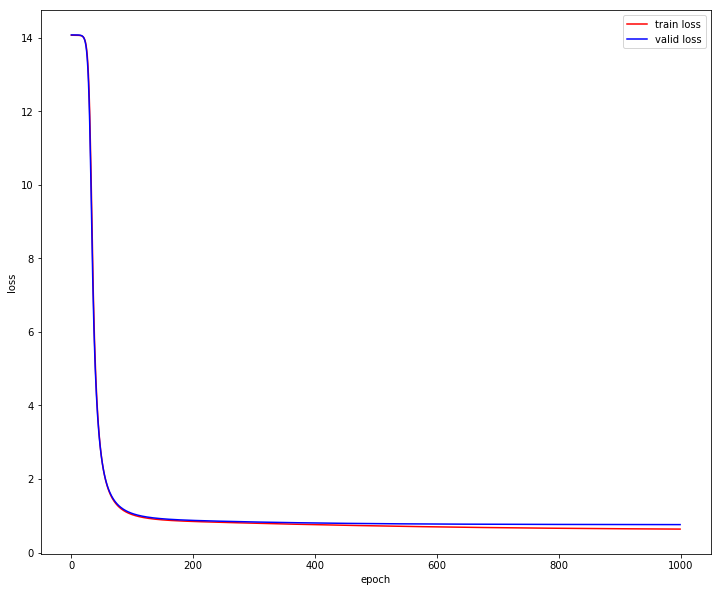

In [10]:
plt.figure(figsize=(12,10))
plt.plot(train_loss_history, color="red", label="train loss")
plt.plot(valid_loss_history, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### results on validation set

In [40]:
results = validset[["gender", "userid","movieid","age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction (rnd.)"] = np.asarray(np.round(final_valid_predictions), dtype=np.int16)
results["prediction (prc.)"] = final_valid_predictions
results.head(5)

,gender,userid,movieid,age_desc,occ_desc,title,genre,rating,prediction (rnd.),prediction (prc.)
39153,F,265,1282,35-44,executive/managerial,Fantasia (1940),Animation|Children's|Musical,5,4,4.294911
191859,M,1182,3897,Under 18,K-12 student,Almost Famous (2000),Comedy|Drama,5,4,3.935581
460069,M,2837,1244,18-24,other or not specified,Manhattan (1979),Comedy|Drama|Romance,4,4,4.125639
517062,M,3191,2719,25-34,programmer,"Haunting, The (1999)",Horror|Thriller,2,2,2.230456
969662,F,5845,908,25-34,clerical/admin,North by Northwest (1959),Drama|Thriller,4,5,4.611377


### Measures

In [93]:
### Precision, Recall, MAE, RMSE measures:

def compute_recall(prediction_col, target_col):
    recall=[]
    for i in range(5):
        rating_df = results[results[target_col]==i+1]
        num_true_rating = len(rating_df)+0.0
        current_recall = (len(rating_df[rating_df[prediction_col]==i+1]))/num_true_rating
        recall.append(current_recall)
    return recall

def compute_precision(prediction_col, target_col): 
    precision=[]
    for i in range(5):
        pred_df = results[results[prediction_col]==i+1]
        pred_rating = len(pred_df)+0.0
        current_precision = (len(pred_df[pred_df[target_col]==i+1]))/pred_rating
        precision.append(current_precision)
    return precision    

def compute_mae(prediction_col, target_col):
    return np.mean(np.abs(results[prediction_col]-results[target_col]))

def compute_rmse(prediction_col, target_col):
    return np.sqrt(1/len(results)*np.sum((results[prediction_col]- results[target_col])**2))

In [66]:
compute_recall('prediction (rnd.)', 'rating')

[0.12306585102554876,
 0.26719748171465607,
 0.5037111538314639,
 0.6389056643564451,
 0.28101879036993543]

In [82]:
compute_precision('prediction (rnd.)', 'rating')

[0.6826347305389222,
 0.3545744942255713,
 0.4086449080768436,
 0.45456405499781755,
 0.6662374273483451]

In [95]:
compute_mae('prediction (rnd.)', 'rating')

0.638839177106141

In [94]:
compute_rmse('prediction (rnd.)', 'rating')

0.91774168163480663